## Model 1

**Dependencies**

In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import random_split
from functools import partial
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
# !pip install ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

**Dataset Summary**

This code reads train.csv into a Pandas DataFrame named "labels" and displays the first five rows of the DataFrame to get an idea about the data.  

In [3]:
labels = pd.read_csv("/kaggle/input/deep-learning-for-msc-2022-23/train.csv")
labels.head(5)

,Filename,Label
0,1.png,0
1,2.png,0
2,3.png,0
3,4.png,0
4,5.png,0


This code line computes the count of unique values in the 'Label' column of the DataFrame to see if there is any class imbalance. Since there is a significant class imbalance, the loss function should be defined accordingly to handle this issue.

In [4]:
value_counts = labels['Label'].value_counts()
value_counts

1    3462
3    2690
0     729
2     679
Name: Label, dtype: int64

**One-hot encoding the label**

This code creates a one-hot encoded version of the 'Label' column in the labels data frame and creates a new binary column for each class.

In [5]:
one_hot = pd.get_dummies(labels['Label'])
labels = labels.join(one_hot)
labels.head(5)

,Filename,Label,0,1,2,3
0,1.png,0,1,0,0,0
1,2.png,0,1,0,0,0
2,3.png,0,1,0,0,0
3,4.png,0,1,0,0,0
4,5.png,0,1,0,0,0


I maintained a hold-out validation set as the evaluation protocol because of its simplicity and flexibility in using different kinds of models. The code below splits the data into a training set and a validation set for an 80%-20% ratio.

In [6]:
train_df, val_df = train_test_split(labels, test_size=0.2, random_state=42)

**Distribution of the labels in Training and Validation sets**

In [8]:
value_counts = train_df['Label'].value_counts()
value_counts

1    2771
3    2168
0     573
2     536
Name: Label, dtype: int64

In [9]:
value_counts = val_df['Label'].value_counts()
value_counts

1    691
3    522
0    156
2    143
Name: Label, dtype: int64

**Custom Data Loaders**  

The code defines a custom dataset called CancerDetectionDataset that reads in a dataframe containing file names of cancer images and their corresponding labels. The dataset reads in the images from a directory specified by root_dir and performs several transforms on each sample. The __getitem__ method of the dataset returns a dictionary containing the image and its corresponding label as tensors. The __len__ method returns the length of the dataset.

In [10]:
class CancerDetectionDataset(Dataset):
    """Cancer detection dataset."""

    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df: Input dataframe.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.labels_frame.iloc[idx, 0]))
        image = io.imread(img_name)
        label = self.labels_frame.iloc[idx, 2:]
        label = np.array(label, dtype = 'float32').reshape((4,))
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

This code defines three transforms: CropCenter, Rescale, and ToTensor. CropCenter crops the center of the image to a specified output size, Rescale resizes the image to a specified output size, and ToTensor converts the image and label to PyTorch tensors.

In [16]:
class CropCenter(object):
    """Crop from the center of the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = int((h - new_h)/2)
        left = int((w - new_w)/2)

        image = image[top: int(top + new_h),
                      left: int(left + new_w)]

        return {'image': image, 'label': label}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).type(torch.float32),
                'label': torch.from_numpy(label).type(torch.float32)}

**Neural Network**

The Net class is a neural network architecture consists of several layers: 3 convolutional layers with padding, 3 pooling layers with padding, and 2 fully connected layers. The network takes a 3-channel image as input and outputs a tensor with 4 values, which correspond to the probabilities of the input image belonging to one of 4 given classes. We use softmax function as the activation function of the last layer because this is a multiclass classification problem. Softmax function guarantees probabilities between 0 and 1 that adds up to 1 for all classes. All the other layers use ReLU activation function to avoid vanishing gradient problem.

In [17]:
class Net(nn.Module):
    def __init__(self, l=120):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, padding=2)
        self.pool = nn.MaxPool2d(3, 3, padding=1)
        self.conv2 = nn.Conv2d(20, 30, 5, padding=2)
        self.conv3 = nn.Conv2d(30, 30, 5, padding=2)
        self.fc1 = nn.Linear(120, l)
        self.fc2 = nn.Linear(l, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 120)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        
        return x

**Loss Function**

This is a custom implementation of weighted cross-entropy loss. If the weight parameter is not None, then the loss is computed with the weighted cross-entropy formula, where the weight tensor is used to assign different weights to each class. If the weight parameter is None, then the regular cross-entropy formula is used. The loss tensor is returned at the end of the forward function. This loss function is used because this is a multiclass classification problem with class imbalance. 

In [18]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight

    def forward(self, input, target):
        if self.weight is not None:
            weight = torch.tensor(self.weight, device=input.device)
            loss = F.cross_entropy(input, target, weight=weight)
        else:
            loss = F.cross_entropy(input, target)
        return loss

**Training and Hyperparameter tuning**

This function trains a neural network using the provided configuration and reports the validation loss and accuracy for each epoch. It uses the CancerDetectionDataset class to load the data and the Net class to define the neural network. It also uses the WeightedCrossEntropyLoss class as the loss function and the Adam optimizer with a default learning rate. Adam optimizer uses both momentum and adaptive learning rate methods that improve the training process even with local minima, saddle points, plateaus, and noisy gradients in the loss function. We crop the middle of the image as a transformation step since the nuclei, which is important in identifying cells, is located in the middle of the image. Further, this step helps in reducing the unnecessary model complexity.  

In [40]:
def Train(config,checkpoint_dir=None, data_dir=None):
    
    # data loading
    train_transformed_dataset = CancerDetectionDataset(train_df,
                                           root_dir="/kaggle/input/deep-learning-for-msc-2022-23/train/",
                                           transform=transforms.Compose([
                                               CropCenter(50),
                                               
                                               ToTensor()
                                           ]))
    val_transformed_dataset = CancerDetectionDataset(val_df,
                                           root_dir="/kaggle/input/deep-learning-for-msc-2022-23/train/",
                                           transform=transforms.Compose([
                                               CropCenter(50),
                                               
                                               ToTensor()
                                               
                                           ]))
    
    train_dataloader = DataLoader(train_transformed_dataset, batch_size=config["batch_size"],
                        shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_transformed_dataset, batch_size=config["batch_size"],
                        shuffle=True, num_workers=0)
    
    # defining the neural network
    net = Net(config["l"])
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    # defining the loss function
    criterion = WeightedCrossEntropyLoss(weight = config["weights"])
    # defining the optimizer
    optimizer = optim.Adam(net.parameters())

    # training
    for epoch in range(config["epochs"]):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data["image"], data["label"]
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1


        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(val_dataloader, 0):
            with torch.no_grad():
                inputs, labels = data["image"], data["label"]
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                predicted = torch.argmax(outputs, axis = 1)
                labels_byclass = torch.argmax(labels, axis = 1)
                total += labels.size(0)
                correct += (predicted == labels_byclass).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")
    return 

Batch size, the number of neurons in the second fully connected layer (l), epochs, and the weights for the loss function are tuned with Ray tune by this code. However, I had to manually test and select a limited set of values for each hyperparameter due to resource constraints.

In [41]:
num_samples=3
gpus_per_trial=2

# parameters for tuning

config = {"batch_size" : tune.choice([1000,500, 200, 100]),
          "l" : tune.choice([64,32, 16]),
          "epochs" : tune.choice([50, 100, 200]),
          "weights" : tune.choice([[0.25,0.25,0.25,0.25], [0.3,0.2,0.3,0.2], [0.4,0.1,0.4,0.1]])
         }

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=10,
        grace_period=1,
        reduction_factor=2)

reporter = CLIReporter(
        metric_columns=["loss", "accuracy", "training_iteration"])


In [42]:
result = tune.run(
        partial(Train),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

== Status ==
Current time: 2023-03-26 15:26:38 (running for 00:00:00.20)
Memory usage on this node: 1.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.23 GiB heap, 0.0/3.61 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_15-26-38
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+-------------------+----------+-----------------+--------------+----------+-----+----------------------+
| Trial name        | status   | loc             |   batch_size |   epochs |   l | weights              |
|-------------------+----------+-----------------+--------------+----------+-----+----------------------|
| Train_99db6_00000 | RUNNING  | 172.19.2.2:1721 |          100 |      100 |  64 | [0.3, 0.2, 0.3, 0.2] |
| Train_99db6_00001 | PENDING  |                 |          200 |      100 |  16 | [0.3, 0.2, 0.3, 0.2] |
| Train_99db6_0000

(func pid=1721) /opt/conda/lib/python3.7/site-packages/ray/_private/workers/default_worker.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=1721)   description=("Parse addresses for the worker to connect to.")


== Status ==
Current time: 2023-03-26 15:26:55 (running for 00:00:17.07)
Memory usage on this node: 5.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.23 GiB heap, 0.0/3.61 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_15-26-38
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+-------------------+----------+-----------------+--------------+----------+-----+----------------------+
| Trial name        | status   | loc             |   batch_size |   epochs |   l | weights              |
|-------------------+----------+-----------------+--------------+----------+-----+----------------------|
| Train_99db6_00000 | RUNNING  | 172.19.2.2:1721 |          100 |      100 |  64 | [0.3, 0.2, 0.3, 0.2] |
| Train_99db6_00001 | PENDING  |                 |          200 |      100 |  16 | [0.3, 0.2, 0.3, 0.2] |
| Train_99db6_0000

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
Train_99db6_00000,0.457011,2023-03-26_15-29-45,True,,6dc44b28e9954d079ab75eb95e546eb0,7e503476845b,10,0.289209,172.19.2.2,1721,True,179.858,16.55,179.858,1679844585,0,,10,99db6_00000,0.00954771
Train_99db6_00001,0.748016,2023-03-26_15-32-49,True,,cb9ccfef584d4fd283817966f8726fac,7e503476845b,10,0.232616,172.19.2.2,3468,True,177.299,16.66,177.299,1679844769,0,,10,99db6_00001,0.00501704
Train_99db6_00002,0.457011,2023-03-26_15-33-21,True,,e5e78a4ccff84d33b4a8798dfcb8703c,7e503476845b,1,0.296189,172.19.2.2,4451,True,25.2594,25.2594,25.2594,1679844801,0,,1,99db6_00002,0.00542903


== Status ==
Current time: 2023-03-26 15:27:18 (running for 00:00:40.19)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.2927577029913664
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.23 GiB heap, 0.0/3.61 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_15-26-38
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+-------------------+----------+-----------------+--------------+----------+-----+----------------------+----------+------------+----------------------+
| Trial name        | status   | loc             |   batch_size |   epochs |   l | weights              |     loss |   accuracy |   training_iteration |
|-------------------+----------+-----------------+--------------+----------+-----+----------------------+----------+------------+----------------------|
| Train_99db6_00000 | RUNNING  | 172.19.2.2:1721 |          100 |      100

(func pid=3468) /opt/conda/lib/python3.7/site-packages/ray/_private/workers/default_worker.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=3468)   description=("Parse addresses for the worker to connect to.")


== Status ==
Current time: 2023-03-26 15:30:02 (running for 00:03:24.31)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.2885268284007907 | Iter 4.000: -0.2928751967847347 | Iter 2.000: -0.29024267196655273 | Iter 1.000: -0.2927577029913664
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.23 GiB heap, 0.0/3.61 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_15-26-38
Number of trials: 3/3 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------+------------+-----------------+--------------+----------+-----+----------------------+----------+------------+----------------------+
| Trial name        | status     | loc             |   batch_size |   epochs |   l | weights              |     loss |   accuracy |   training_iteration |
|-------------------+------------+-----------------+--------------+----------+-----+----------------------+----------+------------+----------------------|
| Train_

(func pid=4451) /opt/conda/lib/python3.7/site-packages/ray/_private/workers/default_worker.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=4451)   description=("Parse addresses for the worker to connect to.")


== Status ==
Current time: 2023-03-26 15:33:05 (running for 00:06:27.69)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.2603858900256455 | Iter 4.000: -0.2625846965238452 | Iter 2.000: -0.2623262023553252 | Iter 1.000: -0.27498316392302513
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.23 GiB heap, 0.0/3.61 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_15-26-38
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+-------------------+------------+-----------------+--------------+----------+-----+----------------------+----------+------------+----------------------+
| Trial name        | status     | loc             |   batch_size |   epochs |   l | weights              |     loss |   accuracy |   training_iteration |
|-------------------+------------+-----------------+--------------+----------+-----+----------------------+----------+------------+----------------------|
| Train_99db6_00002

2023-03-26 15:33:21,332	INFO tune.py:763 -- Total run time: 403.12 seconds (402.96 seconds for the tuning loop).


== Status ==
Current time: 2023-03-26 15:33:21 (running for 00:06:42.98)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2603858900256455 | Iter 4.000: -0.2625846965238452 | Iter 2.000: -0.2623262023553252 | Iter 1.000: -0.2927577029913664
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/7.23 GiB heap, 0.0/3.61 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_15-26-38
Number of trials: 3/3 (3 TERMINATED)
+-------------------+------------+-----------------+--------------+----------+-----+----------------------+----------+------------+----------------------+
| Trial name        | status     | loc             |   batch_size |   epochs |   l | weights              |     loss |   accuracy |   training_iteration |
|-------------------+------------+-----------------+--------------+----------+-----+----------------------+----------+------------+----------------------|
| Train_99db6_00000 | TERMINATED | 

In [43]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

Best trial config: {'batch_size': 200, 'l': 16, 'epochs': 100, 'weights': [0.3, 0.2, 0.3, 0.2]}
Best trial final validation loss: 0.23261641152203083
Best trial final validation accuracy: 0.748015873015873


In [49]:
best_trained_model = Net(16)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

<All keys matched successfully>

**Neural Network Training Curves**

Then, I train a neural network using the best hyperparameters found and plot the training and validation loss as well as the validation accuracy for each epoch to visualize how these metrics change with epochs. The same training code as above is used while keeping validation and training losses and validation accuracy for each epoch.

In [19]:
config_final = {'batch_size': 200, 'l': 16, 'epochs': 100, 'weights': [0.3, 0.2, 0.3, 0.2]}

In [35]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

In [20]:
def Train_final(config,checkpoint_dir=None, data_dir=None):
    
    train_transformed_dataset = CancerDetectionDataset(train_df,
                                           root_dir="/kaggle/input/deep-learning-for-msc-2022-23/train/",
                                           transform=transforms.Compose([
                                               CropCenter(50),
                                               
                                               ToTensor()
                                           ]))
    val_transformed_dataset = CancerDetectionDataset(val_df,
                                           root_dir="/kaggle/input/deep-learning-for-msc-2022-23/train/",
                                           transform=transforms.Compose([
                                               CropCenter(50),
                                               
                                               ToTensor()
                                               
                                           ]))
    
    train_dataloader = DataLoader(train_transformed_dataset, batch_size=config["batch_size"],
                        shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_transformed_dataset, batch_size=config["batch_size"],
                        shuffle=True, num_workers=0)
    
    
    net = Net(config["l"])
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    
    criterion = WeightedCrossEntropyLoss(weight = config["weights"])
    optimizer = optim.Adam(net.parameters())
    
    val_losses = [] # validation loss list for epochs
    train_losses = [] # training loss list for epochs
    val_accuracies = [] # validation accuracy list for epochs

    for epoch in range(config["epochs"]):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data["image"], data["label"]
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1


        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(val_dataloader, 0):
            with torch.no_grad():
                inputs, labels = data["image"], data["label"]
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                predicted = torch.argmax(outputs, axis = 1)
                labels_byclass = torch.argmax(labels, axis = 1)
                total += labels.size(0)
                correct += (predicted == labels_byclass).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        print("epoch: ",epoch," val loss: ",val_loss, " train loss: ", running_loss/4, " val accuracy: ",correct/total)
        val_losses.append(val_loss)
        train_losses.append(running_loss/4)
        val_accuracies.append(correct/total)
        
    print("Finished Training")
    return net,train_dataloader, val_dataloader, val_losses, train_losses, val_accuracies 

In [21]:
net,train_dataloader, val_dataloader, val_losses, train_losses, val_accuracies = Train_final(config_final)

epoch:  0  val loss:  1.9576347321271896  train loss:  2.0006693713366985  val accuracy:  0.6970899470899471
epoch:  1  val loss:  1.9467616379261017  train loss:  1.790525235235691  val accuracy:  0.6944444444444444
epoch:  2  val loss:  1.884593904018402  train loss:  1.8049035370349884  val accuracy:  0.7414021164021164
epoch:  3  val loss:  1.8717922270298004  train loss:  1.7640389129519463  val accuracy:  0.7453703703703703
epoch:  4  val loss:  1.8461010456085205  train loss:  1.751668967306614  val accuracy:  0.753968253968254
epoch:  5  val loss:  1.8573159575462341  train loss:  1.75600341334939  val accuracy:  0.7572751322751323
epoch:  6  val loss:  1.9140275716781616  train loss:  1.752206739038229  val accuracy:  0.718915343915344
epoch:  7  val loss:  1.846965417265892  train loss:  1.7474453747272491  val accuracy:  0.7552910052910053
epoch:  8  val loss:  1.8466769009828568  train loss:  1.7454564832150936  val accuracy:  0.751984126984127
epoch:  9  val loss:  1.85352

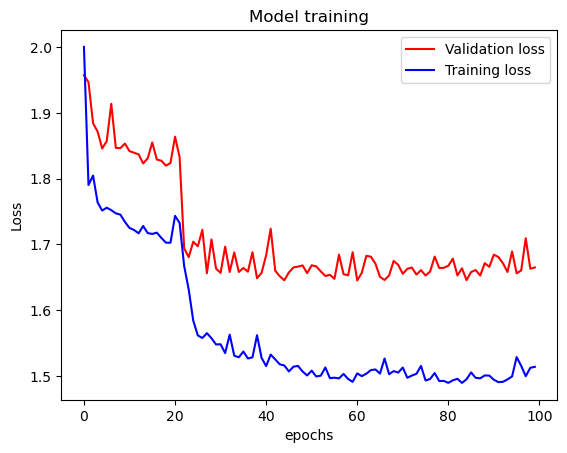

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i for i in range(0,100)]
ax.plot(x, val_losses, color='red', label='Validation loss')
ax.plot(x, train_losses, color='blue', label='Training loss')
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')
ax.set_title('Model training')
ax.legend()
plt.show()

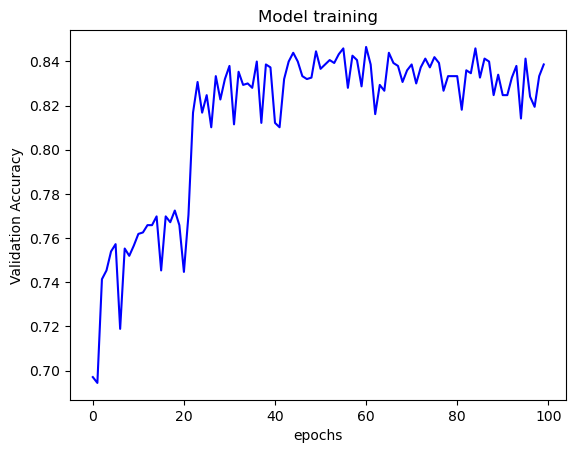

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i for i in range(0,100)]
ax.plot(x, val_accuracies, color='blue', label='Validation accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Model training')
plt.show()

The training and validation loss curves and validation accuracy curve illustrate that the neural network was able to improve its performance on the validation data without overfitting the training data. As the number of epochs increased, the model's performance on the validation data improved gradually, indicating that the model learned meaningful patterns in the data.

**Model Performance**

In [ ]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

In [36]:
from sklearn.metrics import confusion_matrix

def test_accuracy(net,dataloader, device=device):
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for i,data in enumerate(dataloader):
            images, labels = data["image"], data["label"]
            images, labels = images.to(device), labels.to(device)
            # prediction
            outputs = net(images)
            predicted = torch.argmax(outputs, axis = 1)
            labels_byclass = torch.argmax(labels, axis = 1)
            
            # updates total instances and correct instances 
            total += labels.size(0)
            correct += (predicted == labels_byclass).sum().item()
            
            y_true.extend(labels_byclass.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
     
    # confusion matrix generation
    cm = confusion_matrix(y_true, y_pred)
            
    return correct / total, cm

In [37]:
train_accuracy, train_cm = test_accuracy(net,train_dataloader)
val_accuracy, val_cm = test_accuracy(net,val_dataloader)
print ("Training Accuracy: ",train_accuracy)
print ("Validation Accuracy: ",val_accuracy)

Training Accuracy:  0.8971560846560847
Validation Accuracy:  0.8386243386243386


Model has shown reasonably good training and validation accuracy.

**Confusion Matrices**

In [38]:
train_cm

array([[   0,  527,    2,   44],
       [   0, 2753,    4,   14],
       [   0,    9,  517,   10],
       [   0,   12,    0, 2156]])

In [39]:
val_cm

array([[  0, 141,   1,  14],
       [  0, 660,   5,  26],
       [  0,  13, 120,  10],
       [  0,  27,   7, 488]])

According to the confusion matrices, despite assigning a higher weight to class 0, the model still struggles in identifying instances of class 0 accurately. There could be several reasons for this issue. One possibility is that the class imbalance is still too severe to handle even with the increased weight. Another possibility is that the model architecture itself might not be suitable or not complex enough for the task.

**Testing the Neural Network**

The code defines a custom dataset called CancerDetectionDatasetTest similar to CancerDetectionDataset that reads the test images without the labels.

In [59]:
class CancerDetectionDatasetTest(Dataset):
    def __init__(self, folder_path, transform):
        self.folder_path = folder_path
        self.image_paths = sorted(os.listdir(folder_path))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.folder_path, self.image_paths[idx])
        image = io.imread(img_name)
        sample = {'image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensorTest(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).type(torch.float32)}
    
class CropCenterTest(object):
    """Crop from the center of the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = int((h - new_h)/2)
        left = int((w - new_w)/2)

        image = image[top: int(top + new_h),
                      left: int(left + new_w)]

        return {'image': image}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': image}
    


In [69]:
folder_path = "/kaggle/input/deep-learning-for-msc-2022-23/test/"

In [71]:
test_transformed_dataset = CancerDetectionDatasetTest("/kaggle/input/deep-learning-for-msc-2022-23/test/",
                                                     transform=transforms.Compose([CropCenterTest(50),ToTensorTest()]))

In [72]:
test_dataloader = DataLoader(test_transformed_dataset, batch_size=16,
                        shuffle=False, num_workers=0)

The code predicts probabilities for the test images using the trained neural network and finds the class with the maximum probability for each image. The predictions are then converted to a NumPy array and appended to the all_predictions list and then added to a pandas DataFrame and saved as a CSV file.

In [73]:
all_predictions = []
for i, data in enumerate(test_dataloader, 0):
    outputs = net(data['image'])
    predictions = torch.argmax(outputs, axis = 1)
    all_predictions += list(predictions.cpu().detach().numpy())

In [74]:
pred = pd.read_csv("/kaggle/input/deep-learning-for-msc-2022-23/example.csv")
pred.head(5)

,Filename,Label
0,10001.png,0
1,10002.png,0
2,10003.png,0
3,10004.png,0
4,10005.png,0


In [75]:
pred['Label'] = all_predictions
pred.head(5)

,Filename,Label
0,10001.png,3
1,10002.png,3
2,10003.png,2
3,10004.png,3
4,10005.png,3


In [77]:
pred.to_csv("/kaggle/working/submission.csv", index = False)

**Model Interpretation**

Captum Library is used for interpretations

In [80]:
!pip install captum

import torch
import torch.nn.functional as F

import urllib
from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

A set of transformations will be applied to the image before feeding to the model. We ensure that the pixel values are in a specific range, which can improve the performance of the interpretation. Finally, the normalized image tensor is unsqueezed along the first dimension using the unsqueeze() method to add a dimension to the tensor, which is necessary for feeding it into the model trained on batches. 

In [88]:
image_path = "/kaggle/input/deep-learning-for-msc-2022-23/test/10001.png"
transform = transforms.Compose([
 transforms.CenterCrop(50),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

img = Image.open(image_path)
transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Output of the processed image is generated using the model

In [91]:
output = net(input)
label = torch.argmax(outputs, axis = 1)
label

tensor([1])

This function below is then used to find the k largest elements of output along a given dimension. In this case, k is set to 1. Therefore it returns only the largest element. This is similar to the torch.argmax() functionality.

In [ ]:
prediction_score, pred_label_idx = torch.topk(output, 1)

**Attributions**

Then IntegratedGradients function is performed on the neural net to obtain the attributions_ig tensor containing the attributions for each input feature, indicating the contribution of that feature to the prediction for the target class label.

In [94]:
integrated_gradients = IntegratedGradients(net)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

**Visualization of the image and the corresponding attributions by overlaying the latter on the image.**

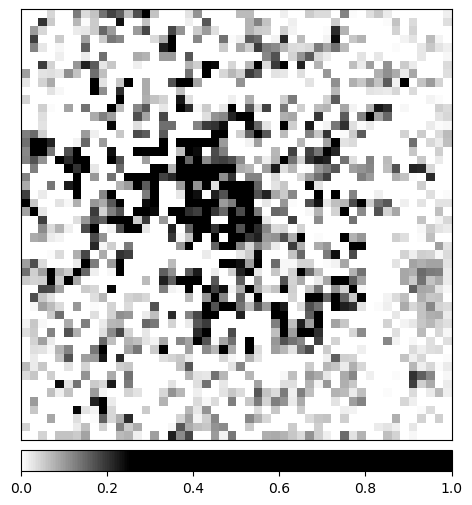

In [96]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

The dark black region within the image represents the pixels that have made the greatest contribution to the prediction

**Noise Tunnel**

This code adds noise to the integrated gradients and visualize the resulting attributions.



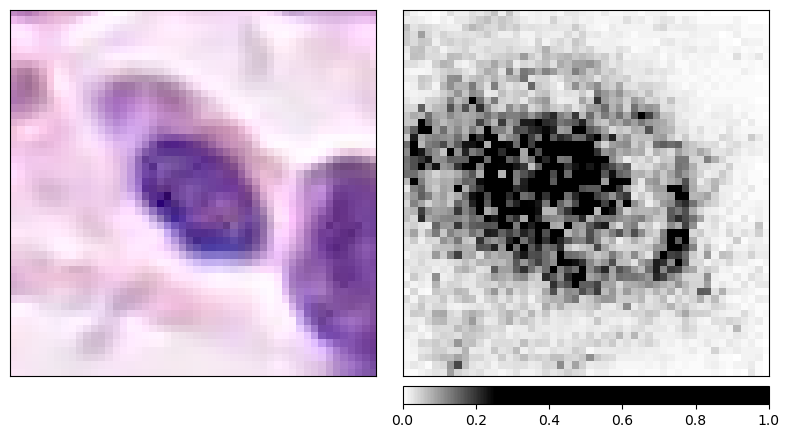

In [98]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

The darker pixels in the attribution map represent the regions of the input image that have the highest contribution toward the model's prediction of the label. 

**GradientShap method**

This computes attribution scores for the input image using the GradientShap method and to visualize the resulting attributions

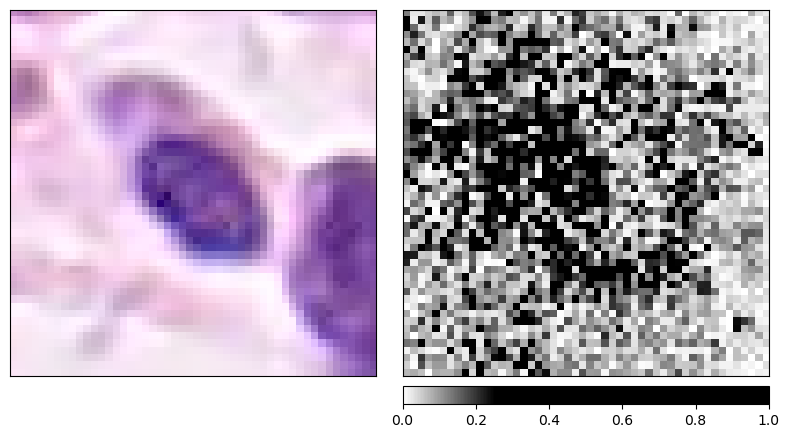

In [101]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(net)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

The darker pixels in the attribution map represent the regions of the input image that have the highest contribution towards the model's prediction of the label.

**Occlusion**

Occlusion is a method that measures the impact of removing parts of the input image on the predictions of the neural network. This is useful to identify which regions of the image are most important for the model's prediction. Occlusion is performed by sliding a small window over the input image and replacing the contents of the window with 0. The difference in the output of the model with and without the window is then used to compute the attribution map.

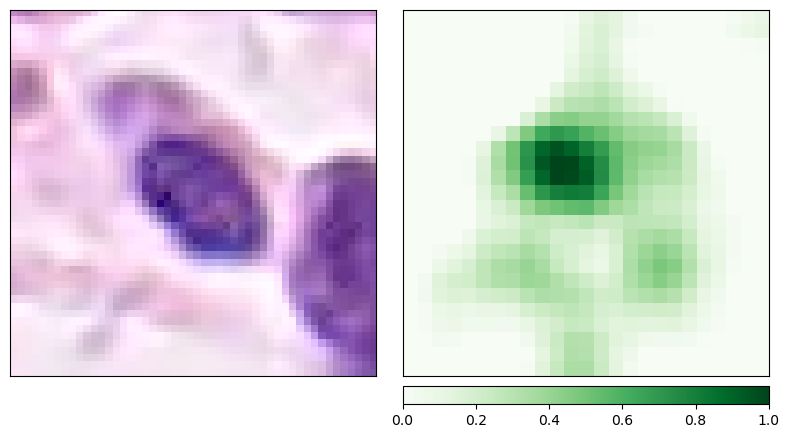

In [110]:
occlusion = Occlusion(net)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 2, 2),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,10, 10),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

The dark green pixels in the attribution map represent the regions of the input image that have the highest contribution toward the model's prediction of the label. 

**All interpretations suggest that the center of the cell nuclei is the key characteristic for identifying the cell type.**

# Model 2

This model shares some similarities with Model 1, including the use of similar functions, classes, data processing steps and dependencies. However, these are defined again because I ran this code as a separate notebook when training and testing.

**Dependencies**

In [2]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import random_split
from functools import partial
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [4]:
# !pip install ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

**Dataset Summary**

In [5]:
labels = pd.read_csv("/kaggle/input/deep-learning-for-msc-2022-23/train.csv")
labels.head(5)

,Filename,Label
0,1.png,0
1,2.png,0
2,3.png,0
3,4.png,0
4,5.png,0


In [6]:
value_counts = labels['Label'].value_counts()
value_counts

1    3462
3    2690
0     729
2     679
Name: Label, dtype: int64

**One-hot encoding the label**

In [7]:
one_hot = pd.get_dummies(labels['Label'])
labels = labels.join(one_hot)
labels.head(5)

,Filename,Label,0,1,2,3
0,1.png,0,1,0,0,0
1,2.png,0,1,0,0,0
2,3.png,0,1,0,0,0
3,4.png,0,1,0,0,0
4,5.png,0,1,0,0,0


In [10]:
train_df, val_df = train_test_split(labels, test_size=0.2, random_state=42)

**Distribution of the labels in Training and Validation sets**

In [11]:
value_counts = train_df['Label'].value_counts()
value_counts

1    2771
3    2168
0     573
2     536
Name: Label, dtype: int64

In [14]:
value_counts = val_df['Label'].value_counts()
value_counts

1    691
3    522
0    156
2    143
Name: Label, dtype: int64

**Custom Data Loaders**  

In [15]:
class CancerDetectionDataset(Dataset):
    """Cancer detection dataset."""

    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.labels_frame.iloc[idx, 0]))
        image = io.imread(img_name)
        label = self.labels_frame.iloc[idx, 2:]
        label = np.array(label, dtype = 'float32').reshape((4,))
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [16]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': label}


class CropCenter(object):
    """Crop from the center of the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = int((h - new_h)/2)
        left = int((w - new_w)/2)

        image = image[top: int(top + new_h),
                      left: int(left + new_w)]

        return {'image': image, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).type(torch.float32),
                'label': torch.from_numpy(label).type(torch.float32)}

**Loss Function**

In [17]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight

    def forward(self, input, target):
        if self.weight is not None:
            weight = torch.tensor(self.weight, device=input.device)
            loss = F.cross_entropy(input, target, weight=weight)
        else:
            loss = F.cross_entropy(input, target)
        return loss

I used a pre-trained ResNet model in which the final fully-connected layer already includes a softmax activation function. This is because the pre-trained ResNet model was originally trained on an image classification task with softmax as the final activation function. Therefore, we do not need to explicitly include a softmax activation function in this example. The number of output units was only changed.

**Training and Hyperparameter tuning**

In [14]:
def Train(config,checkpoint_dir=None, data_dir=None):
    
    train_transformed_dataset = CancerDetectionDataset(train_df,
                                           root_dir="/kaggle/input/deep-learning-for-msc-2022-23/train/",
                                           transform=transforms.Compose([
                                               CropCenter(config["image_size"]),
                                               
                                               ToTensor()
                                           ]))
    val_transformed_dataset = CancerDetectionDataset(val_df,
                                           root_dir="/kaggle/input/deep-learning-for-msc-2022-23/train/",
                                           transform=transforms.Compose([
                                               CropCenter(config["image_size"]),
                                               
                                               ToTensor()
                                               
                                           ]))
    
    train_dataloader = DataLoader(train_transformed_dataset, batch_size=config["batch_size"],
                        shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_transformed_dataset, batch_size=config["batch_size"],
                        shuffle=True, num_workers=0)
    
    # defining model with pretrained resnet101 model
    net = models.resnet101(pretrained=True)
    net = net.eval()
    num_classes = 4 
    net.fc = nn.Linear(2048, num_classes)
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    
    # defining the loss function
    criterion = WeightedCrossEntropyLoss(weight = config["weights"])
    #defining the optimizer
    optimizer = optim.Adam(net.parameters())

    for epoch in range(config["epochs"]):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data["image"], data["label"]
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(val_dataloader, 0):
            with torch.no_grad():
                inputs, labels = data["image"], data["label"]
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                predicted = torch.argmax(outputs, axis = 1)
                labels_byclass = torch.argmax(labels, axis = 1)
                total += labels.size(0)
                correct += (predicted == labels_byclass).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")
    return 

Image size after cropping, batch size, epochs, and the weights for the loss function are tuned with Ray tune by this code. However, I had to manually test and select a limited set of values for each hyperparameter due to resource constraints. 

In [15]:
num_samples=3
gpus_per_trial=2

config = {"image_size" : tune.choice([100, 70, 50]),
          "batch_size" : tune.choice([1000, 500, 200, 100]),
          "epochs" : tune.choice([200, 300, 500]),
          "weights" : tune.choice([[0.25,0.25,0.25,0.25], [0.3,0.2,0.3,0.2], [0.4,0.1,0.4,0.1]])
         }

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=10,
        grace_period=1,
        reduction_factor=2)

reporter = CLIReporter(
        metric_columns=["loss", "accuracy", "training_iteration"])


In [16]:
result = tune.run(
        partial(Train),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

2023-03-26 01:30:27,890	INFO worker.py:1535 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/opt/conda/lib/python3.7/site-packages/ray/tune/trainable/function_trainable.py:612: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  DeprecationWarning,
E0326 01:30:30.996663869      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 01:30:31 (running for 00:00:00.36)
Memory usage on this node: 1.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_01-30-30
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+-------------------+----------+----------------+--------------+----------+--------------+----------------------+
| Trial name        | status   | loc            |   batch_size |   epochs |   image_size | weights              |
|-------------------+----------+----------------+--------------+----------+--------------+----------------------|
| Train_cbe5f_00000 | RUNNING  | 172.19.2.2:325 |          100 |      200 |          100 | [0.3, 0.2, 0.3, 0.2] |
| Train_cbe5f_00001 | PENDING  |                |          500 |      300 |           70 | [

(func pid=325) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=325)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=325) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=325)   warnings.warn(msg)
(func pid=325) Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
  0%|          | 0.00/171M [00:00<?, ?B/s]
  3%|▎         | 5.55M/171M [00:00<00:02,

== Status ==
Current time: 2023-03-26 01:30:42 (running for 00:00:10.89)
Memory usage on this node: 2.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_01-30-30
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+-------------------+----------+----------------+--------------+----------+--------------+----------------------+
| Trial name        | status   | loc            |   batch_size |   epochs |   image_size | weights              |
|-------------------+----------+----------------+--------------+----------+--------------+----------------------|
| Train_cbe5f_00000 | RUNNING  | 172.19.2.2:325 |          100 |      200 |          100 | [0.3, 0.2, 0.3, 0.2] |
| Train_cbe5f_00001 | PENDING  |                |          500 |      300 |           70 | [

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
Train_cbe5f_00000,0.878307,2023-03-26_01-38-00,True,,6c46a4abfdb943c18508d58bbcac7387,ea758826b03e,10,0.0928981,172.19.2.2,325,True,443.215,38.0147,443.215,1679794680,0,,10,cbe5f_00000,0.00720501
Train_cbe5f_00001,0.455688,2023-03-26_01-41-53,True,,04d92802dea941adb6db5b8a6dd175d8,ea758826b03e,8,0.199598,172.19.2.2,2290,True,226.4,26.7409,226.4,1679794913,0,,8,cbe5f_00001,0.0122569
Train_cbe5f_00002,0.457011,2023-03-26_01-42-37,True,,da6214c2398945ca80cb38aa2bb3a6e1,ea758826b03e,1,2.54532,172.19.2.2,2804,True,36.1592,36.1592,36.1592,1679794957,0,,1,cbe5f_00002,0.00729823


== Status ==
Current time: 2023-03-26 01:32:04 (running for 00:01:32.92)
Memory usage on this node: 5.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.24969321303069592
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_01-30-30
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+-------------------+----------+----------------+--------------+----------+--------------+----------------------+----------+------------+----------------------+
| Trial name        | status   | loc            |   batch_size |   epochs |   image_size | weights              |     loss |   accuracy |   training_iteration |
|-------------------+----------+----------------+--------------+----------+--------------+----------------------+----------+------------+----------------------|
| Train_cbe5f_00000 | RUNNING  | 172.19.2.2:325 |

(func pid=2290) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2290)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2290) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2290)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 01:38:12 (running for 00:07:41.06)
Memory usage on this node: 3.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.0998674719594419 | Iter 4.000: -0.2709524044767022 | Iter 2.000: -0.2812983514741063 | Iter 1.000: -0.24969321303069592
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_01-30-30
Number of trials: 3/3 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------+------------+-----------------+--------------+----------+--------------+----------------------+-----------+------------+----------------------+
| Trial name        | status     | loc             |   batch_size |   epochs |   image_size | weights              |      loss |   accuracy |   training_iteration |
|-------------------+------------+-----------------+--------------+----------+--------------+----------------------+-----------+------------+--

(func pid=2804) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=2804)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=2804) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=2804)   warnings.warn(msg)


== Status ==
Current time: 2023-03-26 01:42:06 (running for 00:11:34.68)
Memory usage on this node: 3.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.1497327748220414 | Iter 4.000: -0.264752855990082 | Iter 2.000: -0.2641093940474093 | Iter 1.000: -0.2334906468167901
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_01-30-30
Number of trials: 3/3 (1 RUNNING, 2 TERMINATED)
+-------------------+------------+-----------------+--------------+----------+--------------+----------------------+-----------+------------+----------------------+
| Trial name        | status     | loc             |   batch_size |   epochs |   image_size | weights              |      loss |   accuracy |   training_iteration |
|-------------------+------------+-----------------+--------------+----------+--------------+----------------------+-----------+------------+---------------

2023-03-26 01:42:37,339	INFO tune.py:763 -- Total run time: 726.40 seconds (725.86 seconds for the tuning loop).


== Status ==
Current time: 2023-03-26 01:42:37 (running for 00:12:05.87)
Memory usage on this node: 5.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.1497327748220414 | Iter 4.000: -0.264752855990082 | Iter 2.000: -0.2641093940474093 | Iter 1.000: -0.24969321303069592
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/Train_2023-03-26_01-30-30
Number of trials: 3/3 (3 TERMINATED)
+-------------------+------------+-----------------+--------------+----------+--------------+----------------------+-----------+------------+----------------------+
| Trial name        | status     | loc             |   batch_size |   epochs |   image_size | weights              |      loss |   accuracy |   training_iteration |
|-------------------+------------+-----------------+--------------+----------+--------------+----------------------+-----------+------------+----------------------|
| Tra

In [17]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

Best trial config: {'image_size': 100, 'batch_size': 100, 'epochs': 200, 'weights': [0.3, 0.2, 0.3, 0.2]}
Best trial final validation loss: 0.09289813367649913
Best trial final validation accuracy: 0.8783068783068783


In [ ]:
best_trained_model = models.resnet101(pretrained=True)
best_trained_model = best_trained_model.eval()
num_classes = 4 
best_trained_model.fc = nn.Linear(2048, num_classes)
best_trained_model.fc = nn.Sequential(nn.Linear(2048, num_classes), nn.Softmax(dim=1))

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

**Neural Network Training Curves**

In [18]:
config_final = {'image_size': 100, 'batch_size': 100, 'epochs': 200, 'weights': [0.3, 0.2, 0.3, 0.2]}

In [25]:
def Train_final(config,checkpoint_dir=None, data_dir=None):
    
    train_transformed_dataset = CancerDetectionDataset(train_df,
                                           root_dir="/kaggle/input/deep-learning-for-msc-2022-23/train/",
                                           transform=transforms.Compose([
                                               CropCenter(config["image_size"]),
                                               
                                               ToTensor()
                                           ]))
    val_transformed_dataset = CancerDetectionDataset(val_df,
                                           root_dir="/kaggle/input/deep-learning-for-msc-2022-23/train/",
                                           transform=transforms.Compose([
                                               CropCenter(config["image_size"]),
                                               
                                               ToTensor()
                                               
                                           ]))
    
    train_dataloader = DataLoader(train_transformed_dataset, batch_size=config["batch_size"],
                        shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_transformed_dataset, batch_size=config["batch_size"],
                        shuffle=True, num_workers=0)
    
    net = models.resnet101(pretrained=True)
    num_classes = 4 
    net.fc = nn.Linear(2048, num_classes)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    
    criterion = WeightedCrossEntropyLoss(weight = config["weights"])
    optimizer = optim.Adam(net.parameters())
    
    val_losses = []
    train_losses = []
    val_accuracies = []

    for epoch in range(config["epochs"]):  # loop over the dataset multiple times
        print("epoch:", epoch, " started running.")
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data["image"], data["label"]
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
                
        if epoch%10 == 0:
            
            # Validation loss
            val_loss = 0.0
            val_steps = 0
            total = 0
            correct = 0
            for i, data in enumerate(val_dataloader, 0):
                with torch.no_grad():
                    inputs, labels = data["image"], data["label"]
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = net(inputs)
                    predicted = torch.argmax(outputs, axis = 1)
                    labels_byclass = torch.argmax(labels, axis = 1)
                    total += labels.size(0)
                    correct += (predicted == labels_byclass).sum().item()

                    loss = criterion(outputs, labels)
                    val_loss += loss.cpu().numpy()
                    val_steps += 1

            print("epoch: ",epoch," val loss: ",val_loss, " train loss: ", running_loss/4, " val accuracy: ",correct/total)
            val_losses.append(val_loss)
            train_losses.append(running_loss/4)
            val_accuracies.append(correct/total)
        
    print("Finished Training")
    return net,train_dataloader, val_dataloader, val_losses, train_losses, val_accuracies

In [22]:
net,train_dataloader, val_dataloader, val_losses, train_losses, val_accuracies = Train_final(config_final)

epoch: 0  started running.
epoch:  0  val loss:  0.8335658833384514  train loss:  1.332276494242251  val accuracy:  0.9206349206349206
epoch: 1  started running.
epoch: 2  started running.
epoch: 3  started running.
epoch: 4  started running.
epoch: 5  started running.
epoch: 6  started running.
epoch: 7  started running.
epoch: 8  started running.
epoch: 9  started running.
epoch: 10  started running.
epoch:  10  val loss:  0.5174403334967792  train loss:  0.10276502725901082  val accuracy:  0.9636243386243386
epoch: 11  started running.
epoch: 12  started running.
epoch: 13  started running.
epoch: 14  started running.
epoch: 15  started running.
epoch: 16  started running.
epoch: 17  started running.
epoch: 18  started running.
epoch: 19  started running.
epoch: 20  started running.
epoch:  20  val loss:  0.49364422145299613  train loss:  0.053649465779926686  val accuracy:  0.9715608465608465
epoch: 21  started running.
epoch: 22  started running.
epoch: 23  started running.
epoch:

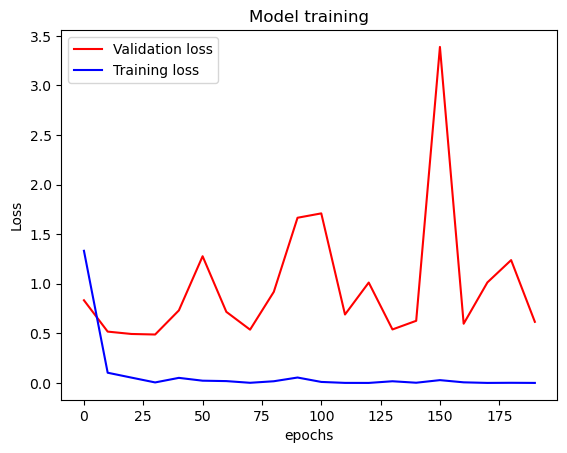

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i for i in range(0,200,10)]
ax.plot(x, val_losses, color='red', label='Validation loss')
ax.plot(x, train_losses, color='blue', label='Training loss')
ax.set_xlabel('epochs')
ax.set_ylabel('Loss')
ax.set_title('Model training')
ax.legend()
plt.show()

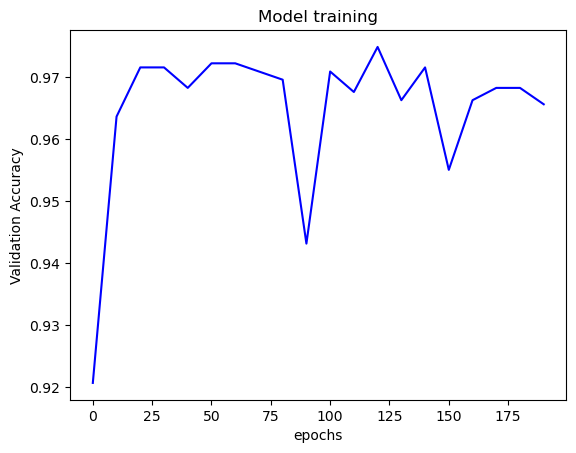

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i for i in range(0,200,10)]
ax.plot(x, val_accuracies, color='blue', label='Validation accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Model training')
plt.show()

After around 30-50 epochs, the validation loss and accuracy show oscillations and a declining performance according to the above plots. It suggests that the model has become overfitted to the training data and is not generalizing well to new, unseen data. To solve this issue, I used the early stopping method.

**Early Stopping**

In [16]:
config_final_earlystopping = {'image_size': 100, 'batch_size': 100, 'epochs': 50, 'weights': [0.3, 0.2, 0.3, 0.2]}

In [17]:
net,train_dataloader, val_dataloader, val_losses, train_losses, val_accuracies = Train_final(config_final_earlystopping)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

epoch: 0  started running.
epoch:  0  val loss:  1.0846886970102787  train loss:  1.3620394943282008  val accuracy:  0.9232804232804233
epoch: 1  started running.
epoch: 2  started running.
epoch: 3  started running.
epoch: 4  started running.
epoch: 5  started running.
epoch: 6  started running.
epoch: 7  started running.
epoch: 8  started running.
epoch: 9  started running.
epoch: 10  started running.
epoch:  10  val loss:  0.6024662768468261  train loss:  0.11450771636009449  val accuracy:  0.951058201058201
epoch: 11  started running.
epoch: 12  started running.
epoch: 13  started running.
epoch: 14  started running.
epoch: 15  started running.
epoch: 16  started running.
epoch: 17  started running.
epoch: 18  started running.
epoch: 19  started running.
epoch: 20  started running.
epoch:  20  val loss:  0.5061925770714879  train loss:  0.15634222989319824  val accuracy:  0.9596560846560847
epoch: 21  started running.
epoch: 22  started running.
epoch: 23  started running.
epoch: 2

**Model Performance**

In [39]:
from sklearn.metrics import confusion_matrix

def test_accuracy(net,dataloader, device=device):
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for i,data in enumerate(dataloader):
            images, labels = data["image"], data["label"]
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = torch.argmax(outputs, axis = 1)
            labels_byclass = torch.argmax(labels, axis = 1)
            total += labels.size(0)
            correct += (predicted == labels_byclass).sum().item()
            
            y_true.extend(labels_byclass.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    cm = confusion_matrix(y_true, y_pred)
            
    return correct / total, cm

In [18]:
model_path = "/kaggle/working/model_best_earlystopping"
torch.save(net.state_dict(), model_path)

In [24]:
train_accuracy, train_cm = test_accuracy(net,train_dataloader)
val_accuracy, val_cm = test_accuracy(net,val_dataloader)
print ("Training Accuracy: ",train_accuracy)
print ("Validation Accuracy: ",val_accuracy)

Training Accuracy:  0.9943783068783069
Validation Accuracy:  0.9636243386243386


This model has shown good training and validation accuracy.

**Confusion Matrices**

In [25]:
train_cm

array([[ 559,   14,    0,    0],
       [   2, 2763,    0,    6],
       [   1,    1,  531,    3],
       [   0,    6,    1, 2161]])

In [26]:
val_cm

array([[140,  13,   0,   3],
       [  1, 686,   1,   3],
       [  0,   2, 128,  13],
       [  5,   8,   6, 503]])

The confusion matrices shows that the model has exhibited good performance in accurately identifying all four classes in the validation set, with only a few instances of misclassification. The model has demonstrated nearly equivalent levels of accuracy across all four classes.

**Testing the Neural Network**

In [42]:
class CancerDetectionDatasetTest(Dataset):
    def __init__(self, folder_path, transform):
        self.folder_path = folder_path
        self.image_paths = sorted(os.listdir(folder_path))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.folder_path, self.image_paths[idx])
        image = io.imread(img_name)
        sample = {'image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensorTest(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).type(torch.float32)}
    
class CropCenterTest(object):
    """Crop from the center of the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = int((h - new_h)/2)
        left = int((w - new_w)/2)

        image = image[top: int(top + new_h),
                      left: int(left + new_w)]

        return {'image': image}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': image}
    


In [23]:
folder_path = "/kaggle/input/deep-learning-for-msc-2022-23/test/"

In [24]:
test_transformed_dataset = CancerDetectionDatasetTest("/kaggle/input/deep-learning-for-msc-2022-23/test/",
                                                     transform=transforms.Compose([CropCenterTest(100),ToTensorTest()]))

In [25]:
test_dataloader = DataLoader(test_transformed_dataset, batch_size=16,
                        shuffle=False, num_workers=0)

In [26]:
all_predictions = []
for i, data in enumerate(test_dataloader, 0):
    outputs = net(data['image'])
    predictions = torch.argmax(outputs, axis = 1)
    all_predictions += list(predictions.cpu().detach().numpy())

In [ ]:
pred = pd.read_csv("/kaggle/input/deep-learning-for-msc-2022-23/example.csv")

In [ ]:
pred['Label'] = all_predictions

In [30]:
pred.to_csv("/kaggle/working/submission.csv", index = False)

**Model Interpretation**

In [32]:
!pip install captum

import torch
import torch.nn.functional as F

import urllib
from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [34]:
image_path = "/kaggle/input/deep-learning-for-msc-2022-23/test/10001.png"
transform = transforms.Compose([
 transforms.CenterCrop(50),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

img = Image.open(image_path)
transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [76]:
image_path = "/kaggle/input/deep-learning-for-msc-2022-23/train/1.png"
transform = transforms.Compose([
 transforms.CenterCrop(50),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

img = Image.open(image_path)
transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [36]:
output = net(input)
label = torch.argmax(outputs, axis = 1)
label

tensor([2])

In [78]:
prediction_score, pred_label_idx = torch.topk(output, 1)

**Attributions**

In [79]:
integrated_gradients = IntegratedGradients(net)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

**Visualization of the image and the corresponding attributions by overlaying the latter on the image.**

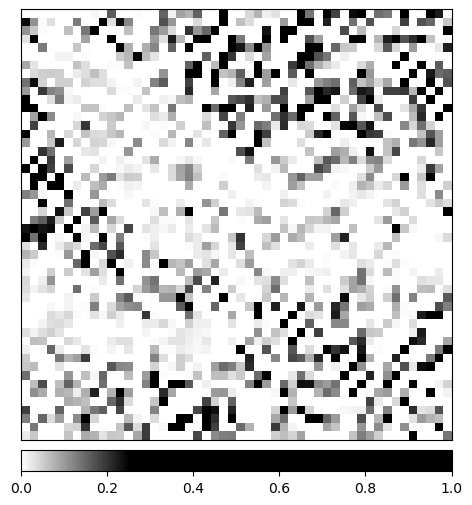

In [82]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Dark black area of the image corresponds to the pixels that had maximum contribution for the prediction.

**Noise Tunnel**

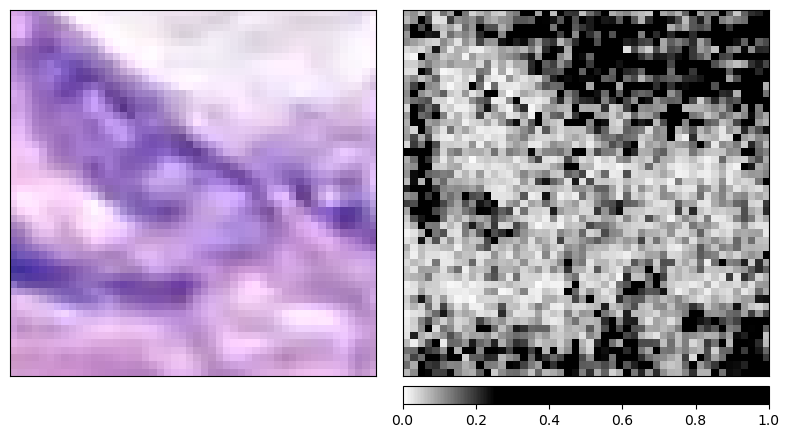

In [83]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

**GradientShap method**

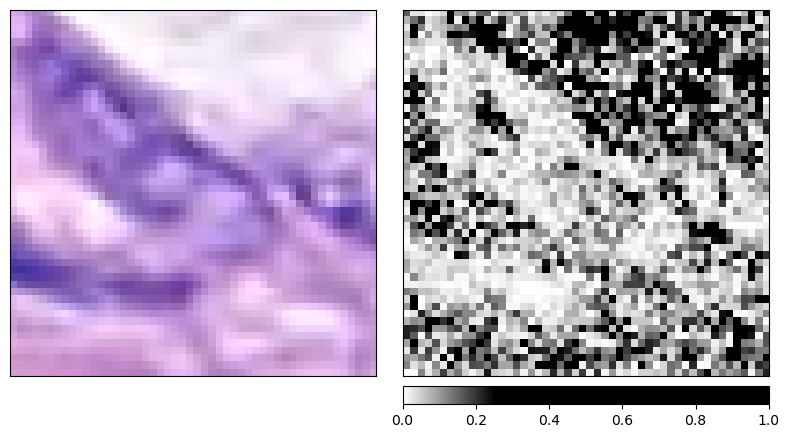

In [84]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(net)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

**Occlusion**

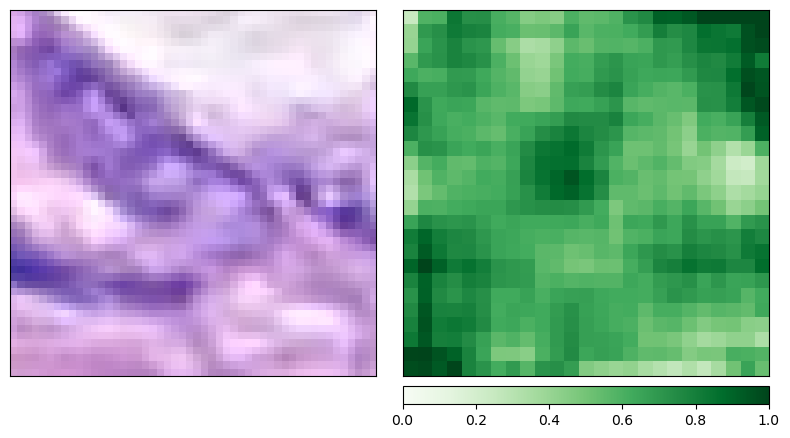

In [87]:
occlusion = Occlusion(net)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 2, 2),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,10, 10),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

The dark green pixels in the attribution map represent the regions of the input image that have the highest contribution towards the model's prediction of the label. 

# Performance Comparison of Models

Based on the confusion matrices generated for the validation data, it is evident that Model 2 outperforms Model 1 in accurately predicting all four classes. Notably, Model 1 showed poor performance in identifying normal epithelial cell nuclei (class 0). Furthermore, the validation and test accuracies indicate that Model 2 achieves an impressive accuracy rate of approximately 96% -93%, while Model 1 performs comparatively at a lower rate of around 84% -83%. These insights suggest that utilizing transfer learning with torchvision models pre-trained on ImageNet gives better results compared to traing a neural network from scratch for the nucleus data.